In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import os
import seaborn as sb
from utils.common import NeuralNet, fit
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.manual_seed(42)

In [9]:
def load_data():
  train = pd.read_csv('Data/TrainingData_Task5.txt', delim_whitespace=True, header=None)
  X = train.iloc[:, 0:2]
  Y = train.iloc[:, -1]
  scaler = MinMaxScaler()
  X_scale = scaler.fit_transform(X)
  return X_scale, Y.to_numpy(dtype=np.float32).reshape(-1, 1), scaler

x, y, scaler = load_data()

Error on validation set: 0.0047759046


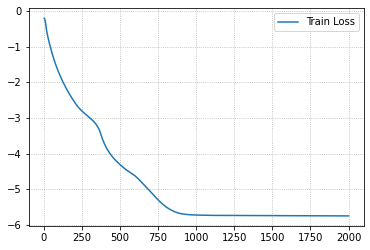

In [10]:
validation_size = int(30*x.shape[0]/100) # 30% of whole data set
training_size = x.shape[0] - validation_size
x_train = x[:training_size,:]
y_train = y[:training_size,:]
    
x_val = x[training_size:,:]
y_val = y[training_size:,:]



inputs = torch.FloatTensor(x_train)
output = torch.from_numpy(y_train)

test_input = torch.FloatTensor(x_val)
test_output = torch.from_numpy(y_val)
batch_size = inputs.shape[0]

training_set = DataLoader(torch.utils.data.TensorDataset(inputs, output), batch_size=batch_size, shuffle=True)


model = NeuralNet(input_dimension=inputs.shape[1],
                      output_dimension=output.shape[1],
                      n_hidden_layers=4,
                      neurons=20,
                      regularization_param=0.0,
                      regularization_exp=1,
                      retrain_seed=128)
optimizer_ = optim.LBFGS(model.parameters(), lr=0.01, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
n_epochs = 2000



history = fit(model, training_set, n_epochs, optimizer_, p=2, verbose=False)



plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, n_epochs + 1), np.log10(history), label="Train Loss")
plt.legend()

print('Error on validation set:', mean_squared_error(model(test_input).detach().numpy(), test_output.detach().numpy(), squared=False) )

In [ ]:
def find_iv(model, x_train, y_train):
  value_counter = 0
  seed = 1
  retrain = 128
  eps = np.finfo(float).eps
  iters = 10
  results = np.empty((iters, 3))
  while value_counter < iters:

    torch.manual_seed(seed)
    y_opt = torch.rand(2, requires_grad=True)

    optimizer = optim.LBFGS([y_opt], lr=float(1e-5), max_iter=50000, max_eval=50000,
                            history_size=100, line_search_fn="strong_wolfe",
                            tolerance_change=1.0 * np.finfo(float).eps)

    optimizer.zero_grad()
    cost = list([0])

    cap_factor = 0.45

    def closure():
        G = (model(y_opt) - cap_factor) ** 2
        #print(G)
        cost[0] = G
        G.backward()
        return G


    optimizer.step(closure=closure)
    # print("Minimizer: ", y_opt)
    # print("Correspodning flux values: ", model(y_opt))
    # print("Value of final cost function: ", cost[0])

    with torch.no_grad():
      pred = model(y_opt).cpu().numpy().reshape(1)
    y_opt = y_opt.cpu().detach().numpy().reshape(1, 2)
    y_opt_scaled = scaler.inverse_transform(y_opt)

    if y_opt_scaled[0, 0] >= 2 and y_opt_scaled[0, 0] <= 20 and \
     y_opt_scaled[0, 1] >= 50 and y_opt_scaled[0, 1] <= 400 and \
     np.abs(pred - cap_factor) < eps:
      #print(f'Success y_opt = {y_opt_scaled} with CF = {pred}')
      #print(f'x.shape: {x_train.shape}, y.shape: {y_train.shape}')
      results[value_counter, :2] = y_opt_scaled
      results[value_counter, -1] = pred
      print(f'Counter = {value_counter}')
      value_counter += 1
      seed += 1
    else:
      #print(f'FAIL y_opt = {y_opt} with CF = {pred}')
      seed += 1

  return x_train, y_train, results

x, y, results = find_iv(model, x_train, y_train)

In [ ]:
# Check if in good range
(results[:, 0].any() < 2 + results[:, 0].any() > 20 + results[:, 1].any() < 50 + results[: 1].any() > 400).sum()

plt.scatter(results[:,0], results[:,1], color = 'blue', label = 'Results')
plt.legend()